# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

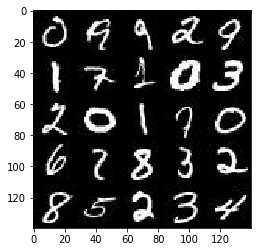

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')


### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

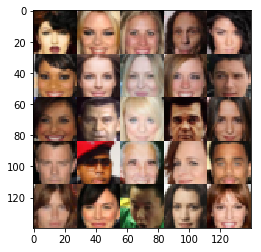

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels));
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32, name='learning_rate')
    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [23]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # First convolution. 
        # We are reducing image width & height by 2 and depth is 16.
        # Image size is 28x28x(1 - MNIST, 3 - celeb)
        layer = tf.layers.conv2d(images, 64, 3, strides=2, padding='same')
        layer = tf.nn.relu(layer)
        # 14x14x64
        
        # Second convolution 
        layer = tf.layers.conv2d(layer, 128, 3, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = tf.nn.relu(layer)
        # 7x7x128

        # Third convolution 
        layer = tf.layers.conv2d(layer, 256, 3, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = tf.nn.relu(layer)
        # 4x4x256

        flat = tf.reshape(layer, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        output = tf.nn.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [24]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        layer = tf.layers.dense(z, 7*7*1024)
        layer = tf.reshape(layer, (-1, 7, 7, 1024))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.nn.relu(layer)
        # 7x7x1024
        
        layer = tf.layers.conv2d_transpose(layer, 512, 3, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training=is_train)
        r1 = tf.nn.relu(layer)
        #14x14x512
                
        layer = tf.layers.conv2d_transpose(layer, 256, 3, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.nn.relu(layer)
        #28x28x256

        layer = tf.layers.conv2d_transpose(layer, out_channel_dim, 3, strides=2, padding='same')
        # 52x52xout_dim
        
        layer = tf.image.resize_images(layer, size=(28, 28))
        # 28x28xoutput_dim 
        
        output = tf.nn.tanh(layer)

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_real_model, d_real_logits = discriminator(input_real, reuse=False)
    d_fake_model, d_fake_logits = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, \
                                                          labels=tf.ones_like(d_real_model) * (1 - smooth)))
    
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, \
                                                            labels=tf.zeros_like(d_fake_model)))
    d_loss = d_real_loss + d_fake_loss
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_model)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print("z_dim=", z_dim)
    print("data_shape=", data_shape)
    print("data_image_mode=", data_image_mode)
    
    out_channel_dim = 3 if data_image_mode == 'RGB' else 1
    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    batch = 0;
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch+=1

                # Batch images value is in range from -0.5 to 0.5
                # But our discriminator expects values from -1 to 1 s
                # So scale the images.  
                batch_images = 2 * batch_images
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                # print("BatchSize=", batch_images.shape)
                sess.run(d_opt, feed_dict = {
                    lr : learning_rate,
                    real_input : batch_images, 
                    z_input : batch_z
                })
                
                sess.run(g_opt, feed_dict = {
                    lr :learning_rate,
                    z_input : batch_z,
                })
                
                if batch % 10 == 0:
                    # run losses. 
                    train_loss_d = sess.run(d_loss, feed_dict = { real_input : batch_images, z_input : batch_z})
                    train_loss_g = sess.run(g_loss, feed_dict =  { z_input : batch_z})
                    print("Epoch {}/{}... Step {}...".format(epoch_i+1, epochs, batch),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                    
                if batch % 100 == 0:
                    print("Generating sample outputs")
                    show_generator_output(sess, 10, z_input, out_channel_dim, data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [18]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
for image in mnist_dataset.get_batches(1):
    # print(image * 2)
    break


z_dim= 100
data_shape= (60000, 28, 28, 1)
data_image_mode= L
Epoch 1/2... Step 10... Discriminator Loss: 6.9720... Generator Loss: 0.5132
Epoch 1/2... Step 20... Discriminator Loss: 14.2391... Generator Loss: 29.0824
Epoch 1/2... Step 30... Discriminator Loss: 3.2022... Generator Loss: 4.4774
Epoch 1/2... Step 40... Discriminator Loss: 2.0526... Generator Loss: 2.9873
Epoch 1/2... Step 50... Discriminator Loss: 2.5723... Generator Loss: 3.7592
Epoch 1/2... Step 60... Discriminator Loss: 2.1125... Generator Loss: 2.8679
Epoch 1/2... Step 70... Discriminator Loss: 1.7092... Generator Loss: 2.1912
Epoch 1/2... Step 80... Discriminator Loss: 1.6048... Generator Loss: 1.8357
Epoch 1/2... Step 90... Discriminator Loss: 1.4952... Generator Loss: 1.6396
Epoch 1/2... Step 100... Discriminator Loss: 1.2867... Generator Loss: 1.3266
Generating sample outputs


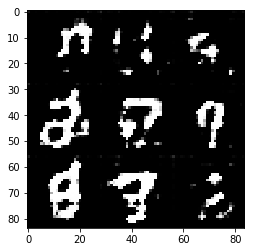

Epoch 1/2... Step 110... Discriminator Loss: 1.4458... Generator Loss: 1.5777
Epoch 1/2... Step 120... Discriminator Loss: 1.2324... Generator Loss: 1.5177
Epoch 1/2... Step 130... Discriminator Loss: 1.4762... Generator Loss: 1.8995
Epoch 1/2... Step 140... Discriminator Loss: 1.5025... Generator Loss: 2.7850
Epoch 1/2... Step 150... Discriminator Loss: 0.8406... Generator Loss: 2.4027
Epoch 1/2... Step 160... Discriminator Loss: 0.9959... Generator Loss: 1.5914
Epoch 1/2... Step 170... Discriminator Loss: 0.9764... Generator Loss: 1.0196
Epoch 1/2... Step 180... Discriminator Loss: 1.7527... Generator Loss: 0.2916
Epoch 1/2... Step 190... Discriminator Loss: 0.5272... Generator Loss: 2.9717
Epoch 1/2... Step 200... Discriminator Loss: 0.4558... Generator Loss: 2.2749
Generating sample outputs


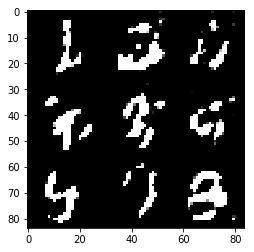

Epoch 1/2... Step 210... Discriminator Loss: 1.1543... Generator Loss: 0.5476
Epoch 1/2... Step 220... Discriminator Loss: 1.7622... Generator Loss: 0.3093
Epoch 1/2... Step 230... Discriminator Loss: 0.7821... Generator Loss: 1.5260
Epoch 1/2... Step 240... Discriminator Loss: 0.4930... Generator Loss: 2.3913
Epoch 1/2... Step 250... Discriminator Loss: 1.2423... Generator Loss: 0.5551
Epoch 1/2... Step 260... Discriminator Loss: 1.0383... Generator Loss: 0.6317
Epoch 1/2... Step 270... Discriminator Loss: 1.4956... Generator Loss: 0.3163
Epoch 1/2... Step 280... Discriminator Loss: 1.9173... Generator Loss: 0.2169
Epoch 1/2... Step 290... Discriminator Loss: 1.2594... Generator Loss: 0.6029
Epoch 1/2... Step 300... Discriminator Loss: 1.1677... Generator Loss: 0.6023
Generating sample outputs


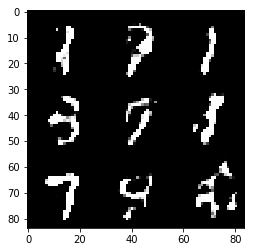

Epoch 1/2... Step 310... Discriminator Loss: 1.3336... Generator Loss: 0.4765
Epoch 1/2... Step 320... Discriminator Loss: 1.0054... Generator Loss: 0.7566
Epoch 1/2... Step 330... Discriminator Loss: 1.0074... Generator Loss: 1.5315
Epoch 1/2... Step 340... Discriminator Loss: 1.1313... Generator Loss: 1.5572
Epoch 1/2... Step 350... Discriminator Loss: 0.8849... Generator Loss: 2.2421
Epoch 1/2... Step 360... Discriminator Loss: 1.1606... Generator Loss: 0.9893
Epoch 1/2... Step 370... Discriminator Loss: 1.3606... Generator Loss: 0.4771
Epoch 1/2... Step 380... Discriminator Loss: 1.8253... Generator Loss: 0.2646
Epoch 1/2... Step 390... Discriminator Loss: 1.5301... Generator Loss: 1.8823
Epoch 1/2... Step 400... Discriminator Loss: 1.5554... Generator Loss: 0.3592
Generating sample outputs


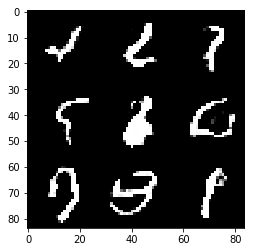

Epoch 1/2... Step 410... Discriminator Loss: 1.3117... Generator Loss: 0.5099
Epoch 1/2... Step 420... Discriminator Loss: 1.8290... Generator Loss: 0.2763
Epoch 1/2... Step 430... Discriminator Loss: 1.2036... Generator Loss: 1.5641
Epoch 1/2... Step 440... Discriminator Loss: 1.2487... Generator Loss: 1.5386
Epoch 1/2... Step 450... Discriminator Loss: 0.9087... Generator Loss: 1.6113
Epoch 1/2... Step 460... Discriminator Loss: 1.5181... Generator Loss: 0.3635
Epoch 2/2... Step 470... Discriminator Loss: 0.8987... Generator Loss: 1.0840
Epoch 2/2... Step 480... Discriminator Loss: 1.2139... Generator Loss: 1.3104
Epoch 2/2... Step 490... Discriminator Loss: 1.2121... Generator Loss: 0.9434
Epoch 2/2... Step 500... Discriminator Loss: 1.1601... Generator Loss: 0.9489
Generating sample outputs


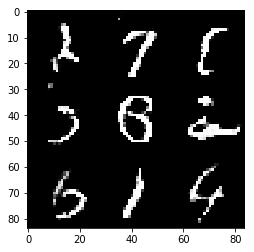

Epoch 2/2... Step 510... Discriminator Loss: 1.2107... Generator Loss: 0.7568
Epoch 2/2... Step 520... Discriminator Loss: 1.3028... Generator Loss: 1.2121
Epoch 2/2... Step 530... Discriminator Loss: 1.2796... Generator Loss: 1.2453
Epoch 2/2... Step 540... Discriminator Loss: 1.1092... Generator Loss: 0.9777
Epoch 2/2... Step 550... Discriminator Loss: 1.2246... Generator Loss: 0.9728
Epoch 2/2... Step 560... Discriminator Loss: 1.3011... Generator Loss: 1.1580
Epoch 2/2... Step 570... Discriminator Loss: 1.7270... Generator Loss: 0.2581
Epoch 2/2... Step 580... Discriminator Loss: 1.4760... Generator Loss: 0.3879
Epoch 2/2... Step 590... Discriminator Loss: 1.3256... Generator Loss: 0.5696
Epoch 2/2... Step 600... Discriminator Loss: 1.1989... Generator Loss: 1.2831
Generating sample outputs


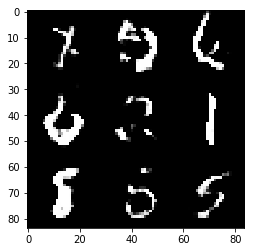

Epoch 2/2... Step 610... Discriminator Loss: 1.2173... Generator Loss: 1.3025
Epoch 2/2... Step 620... Discriminator Loss: 1.2240... Generator Loss: 1.4326
Epoch 2/2... Step 630... Discriminator Loss: 1.3111... Generator Loss: 1.6161
Epoch 2/2... Step 640... Discriminator Loss: 1.0609... Generator Loss: 0.8328
Epoch 2/2... Step 650... Discriminator Loss: 1.0472... Generator Loss: 0.8111
Epoch 2/2... Step 660... Discriminator Loss: 1.0726... Generator Loss: 1.4334
Epoch 2/2... Step 670... Discriminator Loss: 2.0636... Generator Loss: 0.2066
Epoch 2/2... Step 680... Discriminator Loss: 1.3475... Generator Loss: 0.5246
Epoch 2/2... Step 690... Discriminator Loss: 1.3005... Generator Loss: 1.1674
Epoch 2/2... Step 700... Discriminator Loss: 1.1729... Generator Loss: 1.2952
Generating sample outputs


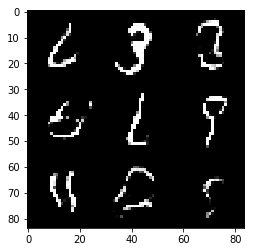

Epoch 2/2... Step 710... Discriminator Loss: 1.0630... Generator Loss: 1.1134
Epoch 2/2... Step 720... Discriminator Loss: 1.2579... Generator Loss: 1.3409
Epoch 2/2... Step 730... Discriminator Loss: 1.0866... Generator Loss: 0.8643
Epoch 2/2... Step 740... Discriminator Loss: 0.9471... Generator Loss: 1.2625
Epoch 2/2... Step 750... Discriminator Loss: 1.0750... Generator Loss: 0.7722
Epoch 2/2... Step 760... Discriminator Loss: 2.6895... Generator Loss: 3.0034
Epoch 2/2... Step 770... Discriminator Loss: 1.2637... Generator Loss: 0.7198
Epoch 2/2... Step 780... Discriminator Loss: 1.3385... Generator Loss: 1.9137
Epoch 2/2... Step 790... Discriminator Loss: 1.0343... Generator Loss: 1.2008
Epoch 2/2... Step 800... Discriminator Loss: 0.9024... Generator Loss: 1.1572
Generating sample outputs


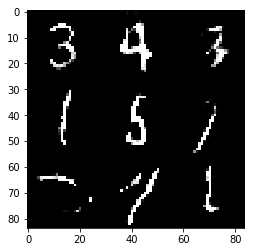

Epoch 2/2... Step 810... Discriminator Loss: 1.0182... Generator Loss: 1.1157
Epoch 2/2... Step 820... Discriminator Loss: 0.7189... Generator Loss: 1.6923
Epoch 2/2... Step 830... Discriminator Loss: 0.9911... Generator Loss: 1.3317
Epoch 2/2... Step 840... Discriminator Loss: 1.6492... Generator Loss: 0.3382
Epoch 2/2... Step 850... Discriminator Loss: 1.0313... Generator Loss: 0.6578
Epoch 2/2... Step 860... Discriminator Loss: 1.9662... Generator Loss: 0.2248
Epoch 2/2... Step 870... Discriminator Loss: 0.9380... Generator Loss: 0.9906
Epoch 2/2... Step 880... Discriminator Loss: 1.3998... Generator Loss: 0.6155
Epoch 2/2... Step 890... Discriminator Loss: 1.2608... Generator Loss: 0.6886
Epoch 2/2... Step 900... Discriminator Loss: 1.0939... Generator Loss: 1.1262
Generating sample outputs


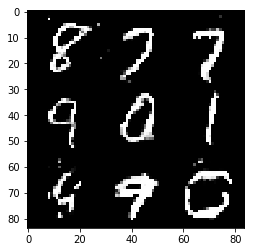

Epoch 2/2... Step 910... Discriminator Loss: 1.1848... Generator Loss: 0.7769
Epoch 2/2... Step 920... Discriminator Loss: 0.8715... Generator Loss: 1.0400
Epoch 2/2... Step 930... Discriminator Loss: 1.6806... Generator Loss: 2.8309


In [25]:
batch_size = 128
z_dim = 100
learning_rate = 0.005
beta1 = 0.2
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

z_dim= 100
data_shape= (202599, 28, 28, 3)
data_image_mode= RGB
Epoch 1/1... Step 10... Discriminator Loss: 0.0045... Generator Loss: 10.4746
Epoch 1/1... Step 20... Discriminator Loss: 0.0002... Generator Loss: 11.3656
Epoch 1/1... Step 30... Discriminator Loss: 0.0038... Generator Loss: 7.0308
Epoch 1/1... Step 40... Discriminator Loss: 0.0025... Generator Loss: 6.5872
Epoch 1/1... Step 50... Discriminator Loss: 0.0148... Generator Loss: 21.9159
Epoch 1/1... Step 60... Discriminator Loss: 0.0089... Generator Loss: 5.3171
Epoch 1/1... Step 70... Discriminator Loss: 12.4177... Generator Loss: 0.0055
Epoch 1/1... Step 80... Discriminator Loss: 0.9634... Generator Loss: 1.0465
Epoch 1/1... Step 90... Discriminator Loss: 3.4204... Generator Loss: 0.0823
Epoch 1/1... Step 100... Discriminator Loss: 0.1555... Generator Loss: 3.0485
Generating sample outputs


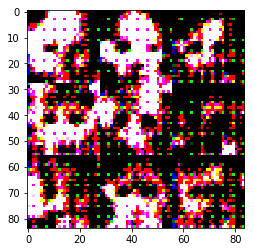

Epoch 1/1... Step 110... Discriminator Loss: 0.1417... Generator Loss: 4.7193
Epoch 1/1... Step 120... Discriminator Loss: 0.6621... Generator Loss: 2.7570
Epoch 1/1... Step 130... Discriminator Loss: 0.0856... Generator Loss: 3.2145
Epoch 1/1... Step 140... Discriminator Loss: 0.0757... Generator Loss: 3.4772
Epoch 1/1... Step 150... Discriminator Loss: 0.1479... Generator Loss: 2.2674
Epoch 1/1... Step 160... Discriminator Loss: 16.6681... Generator Loss: 15.9371
Epoch 1/1... Step 170... Discriminator Loss: 3.3898... Generator Loss: 0.0526
Epoch 1/1... Step 180... Discriminator Loss: 2.2270... Generator Loss: 0.2897
Epoch 1/1... Step 190... Discriminator Loss: 0.5173... Generator Loss: 1.2322
Epoch 1/1... Step 200... Discriminator Loss: 0.7723... Generator Loss: 1.5831
Generating sample outputs


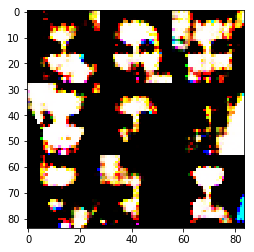

Epoch 1/1... Step 210... Discriminator Loss: 0.8895... Generator Loss: 0.7342
Epoch 1/1... Step 220... Discriminator Loss: 3.1866... Generator Loss: 3.7430
Epoch 1/1... Step 230... Discriminator Loss: 1.5895... Generator Loss: 0.3845
Epoch 1/1... Step 240... Discriminator Loss: 1.5469... Generator Loss: 0.3755
Epoch 1/1... Step 250... Discriminator Loss: 0.7234... Generator Loss: 1.0091
Epoch 1/1... Step 260... Discriminator Loss: 0.9213... Generator Loss: 0.6707
Epoch 1/1... Step 270... Discriminator Loss: 1.2117... Generator Loss: 0.7827
Epoch 1/1... Step 280... Discriminator Loss: 1.1550... Generator Loss: 0.6592
Epoch 1/1... Step 290... Discriminator Loss: 1.2312... Generator Loss: 0.5598
Epoch 1/1... Step 300... Discriminator Loss: 1.1942... Generator Loss: 1.8071
Generating sample outputs


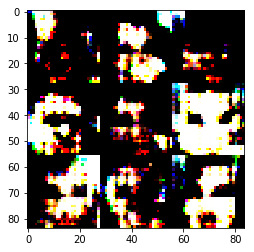

Epoch 1/1... Step 310... Discriminator Loss: 1.6193... Generator Loss: 0.4293
Epoch 1/1... Step 320... Discriminator Loss: 0.7059... Generator Loss: 1.1004
Epoch 1/1... Step 330... Discriminator Loss: 1.0472... Generator Loss: 0.8320
Epoch 1/1... Step 340... Discriminator Loss: 1.2426... Generator Loss: 0.5499
Epoch 1/1... Step 350... Discriminator Loss: 0.8005... Generator Loss: 1.3066
Epoch 1/1... Step 360... Discriminator Loss: 1.6946... Generator Loss: 0.2709
Epoch 1/1... Step 370... Discriminator Loss: 1.4976... Generator Loss: 1.7285
Epoch 1/1... Step 380... Discriminator Loss: 1.7488... Generator Loss: 0.9601
Epoch 1/1... Step 390... Discriminator Loss: 0.8524... Generator Loss: 5.6631
Epoch 1/1... Step 400... Discriminator Loss: 1.5734... Generator Loss: 4.3133
Generating sample outputs


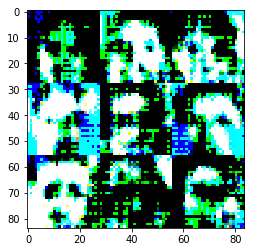

Epoch 1/1... Step 410... Discriminator Loss: 2.4206... Generator Loss: 2.9374
Epoch 1/1... Step 420... Discriminator Loss: 0.6193... Generator Loss: 0.9873
Epoch 1/1... Step 430... Discriminator Loss: 1.7988... Generator Loss: 1.8873
Epoch 1/1... Step 440... Discriminator Loss: 1.2857... Generator Loss: 0.9636
Epoch 1/1... Step 450... Discriminator Loss: 1.1487... Generator Loss: 0.5750
Epoch 1/1... Step 460... Discriminator Loss: 1.2957... Generator Loss: 0.5747
Epoch 1/1... Step 470... Discriminator Loss: 1.1681... Generator Loss: 0.9277
Epoch 1/1... Step 480... Discriminator Loss: 1.1575... Generator Loss: 0.8164
Epoch 1/1... Step 490... Discriminator Loss: 1.8578... Generator Loss: 0.2607
Epoch 1/1... Step 500... Discriminator Loss: 1.2955... Generator Loss: 1.5071
Generating sample outputs


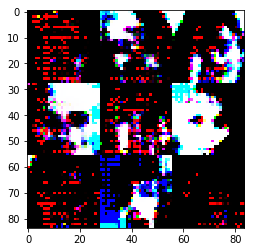

Epoch 1/1... Step 510... Discriminator Loss: 1.2350... Generator Loss: 0.8714
Epoch 1/1... Step 520... Discriminator Loss: 1.1262... Generator Loss: 1.0296
Epoch 1/1... Step 530... Discriminator Loss: 1.5441... Generator Loss: 0.4816
Epoch 1/1... Step 540... Discriminator Loss: 0.9042... Generator Loss: 0.7971
Epoch 1/1... Step 550... Discriminator Loss: 1.3904... Generator Loss: 0.7085
Epoch 1/1... Step 560... Discriminator Loss: 1.4483... Generator Loss: 0.4564
Epoch 1/1... Step 570... Discriminator Loss: 0.8123... Generator Loss: 0.8260
Epoch 1/1... Step 580... Discriminator Loss: 1.1818... Generator Loss: 0.7397
Epoch 1/1... Step 590... Discriminator Loss: 1.5660... Generator Loss: 0.5909
Epoch 1/1... Step 600... Discriminator Loss: 1.2789... Generator Loss: 0.5754
Generating sample outputs


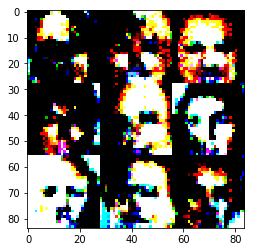

Epoch 1/1... Step 610... Discriminator Loss: 1.1928... Generator Loss: 0.7310
Epoch 1/1... Step 620... Discriminator Loss: 1.0530... Generator Loss: 0.8225
Epoch 1/1... Step 630... Discriminator Loss: 1.7195... Generator Loss: 0.2649
Epoch 1/1... Step 640... Discriminator Loss: 1.6808... Generator Loss: 0.3069
Epoch 1/1... Step 650... Discriminator Loss: 1.1154... Generator Loss: 0.5978
Epoch 1/1... Step 660... Discriminator Loss: 0.9808... Generator Loss: 1.0030
Epoch 1/1... Step 670... Discriminator Loss: 1.3024... Generator Loss: 0.8294
Epoch 1/1... Step 680... Discriminator Loss: 1.1090... Generator Loss: 0.6947
Epoch 1/1... Step 690... Discriminator Loss: 1.3030... Generator Loss: 0.6163
Epoch 1/1... Step 700... Discriminator Loss: 1.6444... Generator Loss: 0.6578
Generating sample outputs


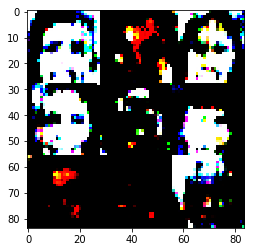

Epoch 1/1... Step 710... Discriminator Loss: 1.4042... Generator Loss: 0.8256
Epoch 1/1... Step 720... Discriminator Loss: 1.4473... Generator Loss: 0.7464
Epoch 1/1... Step 730... Discriminator Loss: 1.1422... Generator Loss: 0.6859
Epoch 1/1... Step 740... Discriminator Loss: 1.3084... Generator Loss: 0.9074
Epoch 1/1... Step 750... Discriminator Loss: 1.3024... Generator Loss: 1.0257
Epoch 1/1... Step 760... Discriminator Loss: 1.2829... Generator Loss: 0.9842
Epoch 1/1... Step 770... Discriminator Loss: 0.9162... Generator Loss: 0.9715
Epoch 1/1... Step 780... Discriminator Loss: 1.1131... Generator Loss: 0.6241
Epoch 1/1... Step 790... Discriminator Loss: 0.7651... Generator Loss: 0.8997
Epoch 1/1... Step 800... Discriminator Loss: 0.9845... Generator Loss: 0.8240
Generating sample outputs


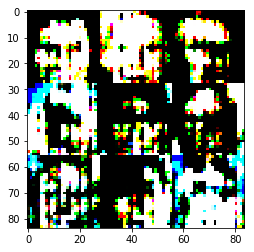

Epoch 1/1... Step 810... Discriminator Loss: 1.4854... Generator Loss: 0.7342
Epoch 1/1... Step 820... Discriminator Loss: 1.1189... Generator Loss: 0.6039
Epoch 1/1... Step 830... Discriminator Loss: 1.6588... Generator Loss: 0.3850
Epoch 1/1... Step 840... Discriminator Loss: 1.1185... Generator Loss: 0.8128
Epoch 1/1... Step 850... Discriminator Loss: 1.9995... Generator Loss: 0.2354
Epoch 1/1... Step 860... Discriminator Loss: 0.5985... Generator Loss: 1.2534
Epoch 1/1... Step 870... Discriminator Loss: 0.2344... Generator Loss: 2.0674
Epoch 1/1... Step 880... Discriminator Loss: 1.7950... Generator Loss: 0.3595
Epoch 1/1... Step 890... Discriminator Loss: 0.5021... Generator Loss: 1.3913
Epoch 1/1... Step 900... Discriminator Loss: 0.6545... Generator Loss: 1.3333
Generating sample outputs


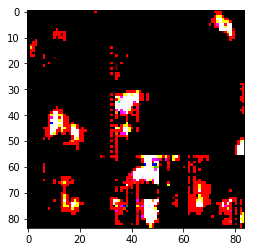

Epoch 1/1... Step 910... Discriminator Loss: 2.0721... Generator Loss: 0.2980
Epoch 1/1... Step 920... Discriminator Loss: 1.4843... Generator Loss: 0.6317
Epoch 1/1... Step 930... Discriminator Loss: 0.8018... Generator Loss: 1.1550
Epoch 1/1... Step 940... Discriminator Loss: 1.2199... Generator Loss: 0.5885
Epoch 1/1... Step 950... Discriminator Loss: 1.0951... Generator Loss: 0.9774
Epoch 1/1... Step 960... Discriminator Loss: 1.6342... Generator Loss: 1.1817
Epoch 1/1... Step 970... Discriminator Loss: 1.2960... Generator Loss: 1.1255
Epoch 1/1... Step 980... Discriminator Loss: 1.4710... Generator Loss: 0.7443
Epoch 1/1... Step 990... Discriminator Loss: 1.0697... Generator Loss: 0.7117
Epoch 1/1... Step 1000... Discriminator Loss: 1.2003... Generator Loss: 0.5978
Generating sample outputs


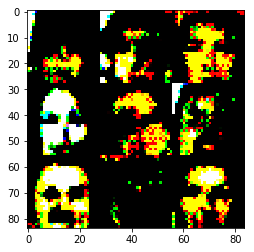

Epoch 1/1... Step 1010... Discriminator Loss: 1.2377... Generator Loss: 0.7285
Epoch 1/1... Step 1020... Discriminator Loss: 1.1702... Generator Loss: 0.9153
Epoch 1/1... Step 1030... Discriminator Loss: 1.3174... Generator Loss: 0.6374
Epoch 1/1... Step 1040... Discriminator Loss: 1.4345... Generator Loss: 1.7222
Epoch 1/1... Step 1050... Discriminator Loss: 1.2126... Generator Loss: 0.6097
Epoch 1/1... Step 1060... Discriminator Loss: 0.9667... Generator Loss: 0.5741
Epoch 1/1... Step 1070... Discriminator Loss: 1.3491... Generator Loss: 0.6255
Epoch 1/1... Step 1080... Discriminator Loss: 1.2779... Generator Loss: 0.7794
Epoch 1/1... Step 1090... Discriminator Loss: 1.2454... Generator Loss: 0.8635
Epoch 1/1... Step 1100... Discriminator Loss: 1.0764... Generator Loss: 0.6507
Generating sample outputs


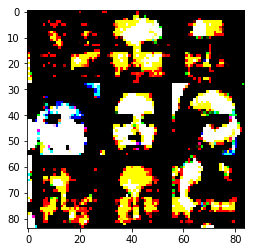

Epoch 1/1... Step 1110... Discriminator Loss: 1.2284... Generator Loss: 0.8507
Epoch 1/1... Step 1120... Discriminator Loss: 0.5314... Generator Loss: 1.2618
Epoch 1/1... Step 1130... Discriminator Loss: 0.8230... Generator Loss: 0.7601
Epoch 1/1... Step 1140... Discriminator Loss: 0.7299... Generator Loss: 1.0183
Epoch 1/1... Step 1150... Discriminator Loss: 1.1323... Generator Loss: 0.5110
Epoch 1/1... Step 1160... Discriminator Loss: 0.2602... Generator Loss: 1.8447
Epoch 1/1... Step 1170... Discriminator Loss: 0.2220... Generator Loss: 1.8165
Epoch 1/1... Step 1180... Discriminator Loss: 0.5556... Generator Loss: 1.1749
Epoch 1/1... Step 1190... Discriminator Loss: 1.0539... Generator Loss: 1.7286
Epoch 1/1... Step 1200... Discriminator Loss: 0.8994... Generator Loss: 1.1905
Generating sample outputs


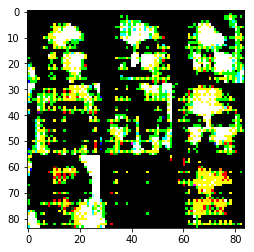

Epoch 1/1... Step 1210... Discriminator Loss: 0.8363... Generator Loss: 0.7065
Epoch 1/1... Step 1220... Discriminator Loss: 3.5350... Generator Loss: 0.0544
Epoch 1/1... Step 1230... Discriminator Loss: 0.5001... Generator Loss: 1.2638
Epoch 1/1... Step 1240... Discriminator Loss: 0.8612... Generator Loss: 1.0306
Epoch 1/1... Step 1250... Discriminator Loss: 1.3686... Generator Loss: 1.1574
Epoch 1/1... Step 1260... Discriminator Loss: 0.9727... Generator Loss: 0.8985
Epoch 1/1... Step 1270... Discriminator Loss: 1.0428... Generator Loss: 0.7756
Epoch 1/1... Step 1280... Discriminator Loss: 0.4227... Generator Loss: 1.5613
Epoch 1/1... Step 1290... Discriminator Loss: 0.9094... Generator Loss: 0.9365
Epoch 1/1... Step 1300... Discriminator Loss: 0.3176... Generator Loss: 2.0897
Generating sample outputs


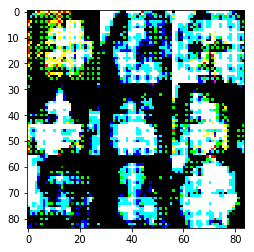

Epoch 1/1... Step 1310... Discriminator Loss: 0.9902... Generator Loss: 1.0649
Epoch 1/1... Step 1320... Discriminator Loss: 1.1150... Generator Loss: 0.6794
Epoch 1/1... Step 1330... Discriminator Loss: 1.1891... Generator Loss: 0.5949
Epoch 1/1... Step 1340... Discriminator Loss: 0.8940... Generator Loss: 0.7233
Epoch 1/1... Step 1350... Discriminator Loss: 1.5622... Generator Loss: 0.4018
Epoch 1/1... Step 1360... Discriminator Loss: 1.3666... Generator Loss: 0.6143
Epoch 1/1... Step 1370... Discriminator Loss: 2.0027... Generator Loss: 0.3524
Epoch 1/1... Step 1380... Discriminator Loss: 1.1711... Generator Loss: 0.4821
Epoch 1/1... Step 1390... Discriminator Loss: 0.4459... Generator Loss: 1.5889
Epoch 1/1... Step 1400... Discriminator Loss: 1.6304... Generator Loss: 0.3674
Generating sample outputs


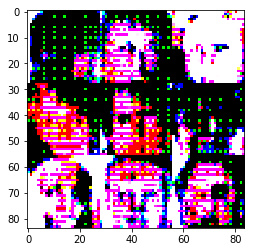

Epoch 1/1... Step 1410... Discriminator Loss: 0.7933... Generator Loss: 5.9683
Epoch 1/1... Step 1420... Discriminator Loss: 1.1662... Generator Loss: 1.4946
Epoch 1/1... Step 1430... Discriminator Loss: 0.6008... Generator Loss: 1.2932
Epoch 1/1... Step 1440... Discriminator Loss: 0.5660... Generator Loss: 1.5587
Epoch 1/1... Step 1450... Discriminator Loss: 0.1474... Generator Loss: 3.2190
Epoch 1/1... Step 1460... Discriminator Loss: 0.5565... Generator Loss: 1.7867
Epoch 1/1... Step 1470... Discriminator Loss: 1.0208... Generator Loss: 1.9796
Epoch 1/1... Step 1480... Discriminator Loss: 0.7556... Generator Loss: 0.9217
Epoch 1/1... Step 1490... Discriminator Loss: 0.3725... Generator Loss: 2.2389
Epoch 1/1... Step 1500... Discriminator Loss: 1.1026... Generator Loss: 0.8969
Generating sample outputs


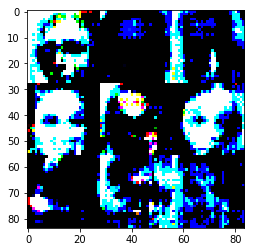

Epoch 1/1... Step 1510... Discriminator Loss: 2.2590... Generator Loss: 0.3261
Epoch 1/1... Step 1520... Discriminator Loss: 0.5721... Generator Loss: 2.0036
Epoch 1/1... Step 1530... Discriminator Loss: 1.4018... Generator Loss: 1.0609
Epoch 1/1... Step 1540... Discriminator Loss: 0.9122... Generator Loss: 0.8383
Epoch 1/1... Step 1550... Discriminator Loss: 1.0633... Generator Loss: 0.6571
Epoch 1/1... Step 1560... Discriminator Loss: 0.7148... Generator Loss: 1.0350
Epoch 1/1... Step 1570... Discriminator Loss: 1.9328... Generator Loss: 0.2237
Epoch 1/1... Step 1580... Discriminator Loss: 0.7977... Generator Loss: 0.8851


In [26]:
batch_size = 128
z_dim = 100
learning_rate = 0.005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.